In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

d:\Code\大學\人工智慧概論\期末計劃 - 聲音辨識\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

def display_spectrogram(audio_array: np.ndarray):
  plt.specgram(audio_array, NFFT=400, Fs=SAMPLE_RATE)
  plt.show()

In [23]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000
SHIFT = 10

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [18]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.num_mels = 64
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    self.ms = MelSpectrogram(SAMPLE_RATE, n_mels=self.num_mels)
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        self.voices[-1].append(torch.tensor(load_voice(f"./data/bark/{folder_name}/{fn}"), dtype=torch.float))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices) * self.k)
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim]).numpy())
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(self.ms(t[r:r + self.embedding_dim]).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim]).numpy())
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim]).float()).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [19]:
dataset = VoiceDataset("./data/bark")
# torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [20]:
# dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

In [90]:
class Judge(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(4),
      nn.ReLU(True),
      nn.Conv2d(64, 128, 2),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Conv2d(128, 256, 2),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(2),
      nn.ReLU(True)
    )
    self.lstm = nn.LSTM(256, 256, 1, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 40, 256),
      nn.ReLU(True),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs2 = self.seq1(target.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs1, _ = self.lstm(outputs1.squeeze(2).permute(0, 2, 1))
    outputs2, _ = self.lstm(outputs2.squeeze(2).permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    return outputs

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.judge = Judge()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [ ]:
samples, targets, labels = next(iter(dataloader))
model = Judge()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][0].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][1].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][2].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), targets[0][0].numpy())
plt.show()
print(model(samples[0], targets[0]))
print(model(samples[1], targets[1]))

In [91]:
samples, targets, labels = next(iter(dataloader))
model = Model()
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 64, 361]) torch.Size([4, 10, 64, 361])
tensor([[0.1000, 0.1001, 0.0998, 0.1002, 0.1000, 0.1001, 0.0999, 0.0999, 0.0999,
         0.0999],
        [0.0999, 0.1000, 0.1001, 0.1000, 0.1000, 0.1001, 0.1000, 0.0999, 0.1000,
         0.1000],
        [0.0999, 0.1001, 0.1002, 0.0999, 0.0999, 0.0999, 0.1000, 0.1001, 0.1001,
         0.0999],
        [0.0997, 0.0999, 0.1003, 0.1001, 0.0999, 0.1000, 0.1000, 0.1001, 0.1000,
         0.1000]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
tensor(2.3025, grad_fn=<DivBackward1>)


In [92]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.k)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

100/10000:	2.3026
200/10000:	2.3024
300/10000:	2.3021
400/10000:	2.3018
500/10000:	2.2996
600/10000:	2.2987
700/10000:	2.2937
800/10000:	2.2861
900/10000:	2.2811
1000/10000:	2.2799
1100/10000:	2.2762
1200/10000:	2.2724
1300/10000:	2.2638
1400/10000:	2.2672
1500/10000:	2.2570
1600/10000:	2.2543
1700/10000:	2.2524
1800/10000:	2.2514
1900/10000:	2.2484
2000/10000:	2.2471
2100/10000:	2.2454
2200/10000:	2.2461
2300/10000:	2.2448
2400/10000:	2.2403
2500/10000:	2.2404
2600/10000:	2.2432
2700/10000:	2.2405
2800/10000:	2.2407
2900/10000:	2.2390
3000/10000:	2.2412
3100/10000:	2.2345
3200/10000:	2.2400
3300/10000:	2.2357
3400/10000:	2.2362
3500/10000:	2.2375
3600/10000:	2.2364
3700/10000:	2.2387
3800/10000:	2.2354
3900/10000:	2.2327
4000/10000:	2.2360
4100/10000:	2.2348
4200/10000:	2.2346
4300/10000:	2.2318
4400/10000:	2.2348
4500/10000:	2.2347
4600/10000:	2.2323
4700/10000:	2.2292
4800/10000:	2.2325
4900/10000:	2.2308
5000/10000:	2.2333
5100/10000:	2.2296
5200/10000:	2.2322
5300/10000:	2.2286
54

In [44]:
with torch.no_grad():
  t = load_voice("./data/bark/woman-2.wav")
  samples, targets = dataset.get_selected(t)
  outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
  print(np.round(outputs.cpu().numpy(), 3))
  print(outputs.cpu().numpy().argmax() + 1)
  pprint(dataset.base_map)
  display(Audio(samples[0], rate=SAMPLE_RATE))
  display(Audio(targets[0], rate=SAMPLE_RATE))
  display(Audio(samples[1], rate=SAMPLE_RATE))
  display(Audio(targets[1], rate=SAMPLE_RATE))
  display(Audio(samples[2], rate=SAMPLE_RATE))
  display(Audio(targets[2], rate=SAMPLE_RATE))

[[0.333 0.333 0.333]]
3
{'man-1': 1, 'woman-1': 2, 'woman-2': 3}


100%|██████████| 1000/1000 [00:17<00:00, 57.87it/s]


array([[0.1665476 , 0.07314657, 0.07403886, 0.12027096, 0.18060876,
        0.08763114, 0.07324645, 0.07823757, 0.07313605, 0.07313604]])

array([367.,   0.,   3., 117., 470.,  32.,   0.,  11.,   0.,   0.])

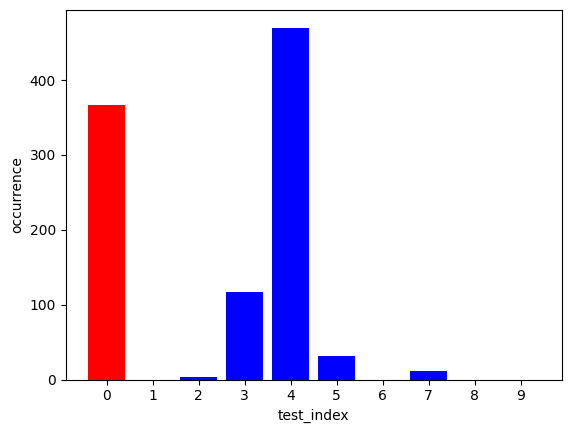

100%|██████████| 1000/1000 [00:18<00:00, 53.01it/s]


array([[0.07437746, 0.19679588, 0.19107534, 0.07745035, 0.07426214,
        0.08968744, 0.0740874 , 0.07408919, 0.0740874 , 0.0740874 ]])

array([  1., 505., 481.,   2.,   0.,  11.,   0.,   0.,   0.,   0.])

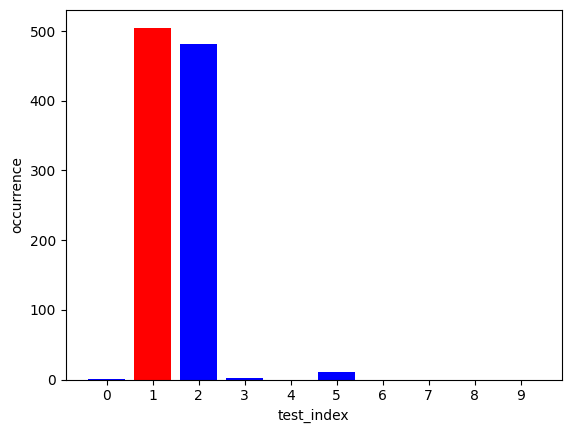

100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]


array([[0.07481599, 0.20102594, 0.19936848, 0.07490742, 0.07481589,
        0.07580279, 0.07481587, 0.07481587, 0.07481587, 0.07481587]])

array([  0., 416., 584.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

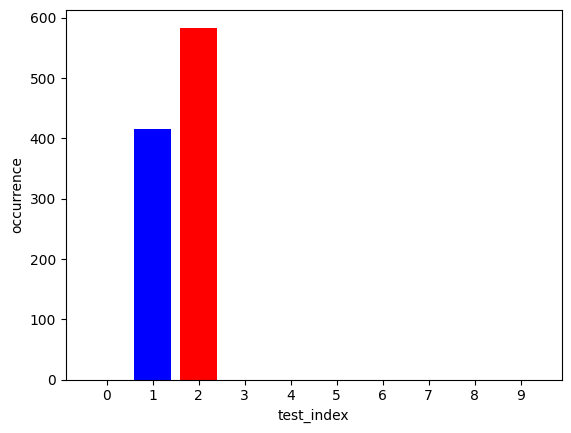

100%|██████████| 1000/1000 [00:19<00:00, 52.25it/s]


array([[0.09218918, 0.08455531, 0.07959424, 0.180697  , 0.07894329,
        0.19127959, 0.07312113, 0.07337798, 0.07312113, 0.07312113]])

array([ 28.,  17.,   8., 292.,   2., 653.,   0.,   0.,   0.,   0.])

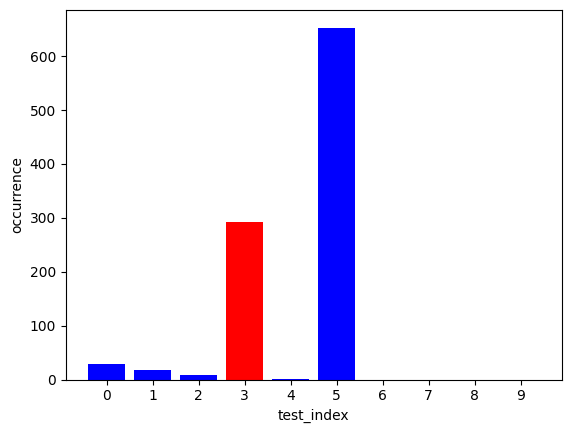

100%|██████████| 1000/1000 [00:19<00:00, 52.63it/s]


array([[0.1334692 , 0.07238825, 0.07271121, 0.16385536, 0.13801065,
        0.13125753, 0.07155867, 0.07363257, 0.07155828, 0.07155828]])

array([202.,   1.,   5., 411., 186., 189.,   0.,   6.,   0.,   0.])

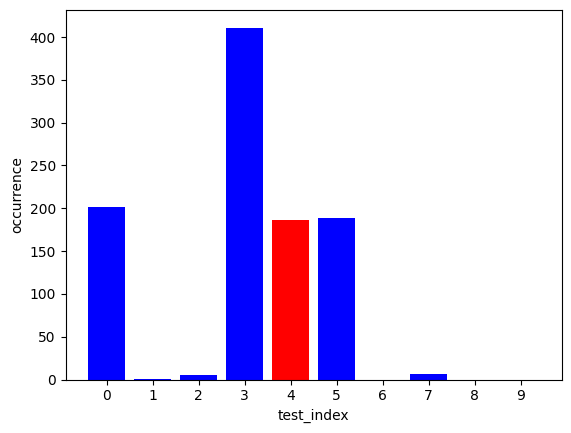

100%|██████████| 1000/1000 [00:19<00:00, 51.20it/s]


array([[0.08947667, 0.09881577, 0.09077695, 0.16260673, 0.08330668,
        0.18136594, 0.07327859, 0.07381553, 0.07327857, 0.07327857]])

array([ 30.,  84.,  44., 258.,   6., 577.,   0.,   1.,   0.,   0.])

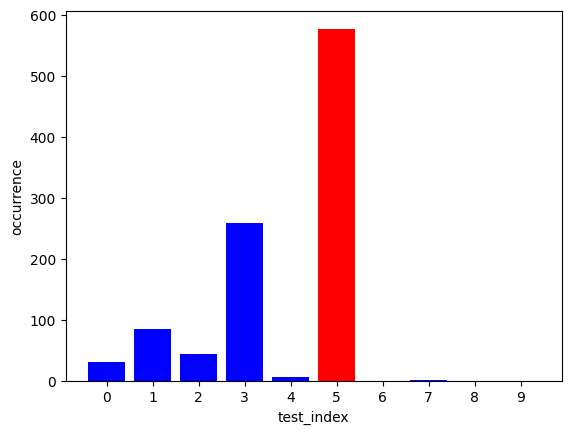

100%|██████████| 1000/1000 [00:19<00:00, 52.47it/s]


array([[0.12308812, 0.07655902, 0.07684588, 0.08421105, 0.1173003 ,
        0.08080625, 0.12047604, 0.15473612, 0.08334088, 0.08263635]])

array([183.,   0.,   0.,  20., 135.,  14., 176., 429.,  25.,  18.])

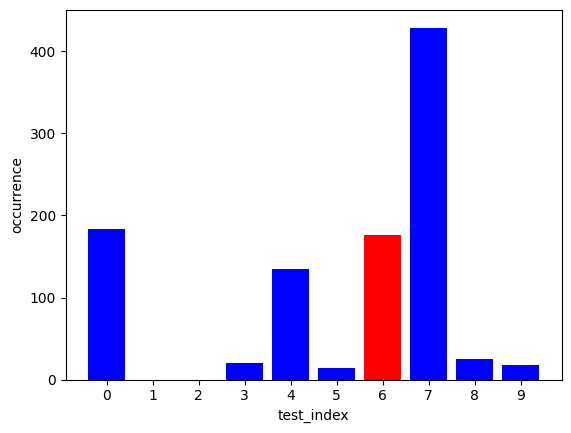

100%|██████████| 1000/1000 [00:19<00:00, 52.33it/s]


array([[0.1656605 , 0.07669041, 0.07744935, 0.08857493, 0.17317325,
        0.08057632, 0.0792129 , 0.10528153, 0.0766904 , 0.0766904 ]])

array([453.,   0.,   3.,  33., 436.,  10.,   5.,  60.,   0.,   0.])

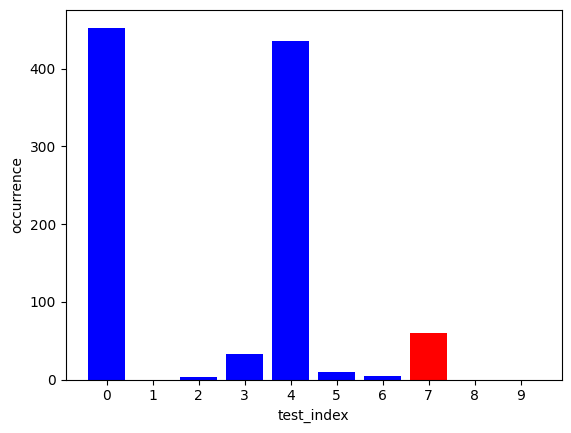

100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]


array([[0.0709427 , 0.06858262, 0.06986635, 0.06858262, 0.07072282,
        0.07009407, 0.14273857, 0.08869982, 0.17597265, 0.17379778]])

array([  5.,   0.,   6.,   0.,   4.,   4., 182.,  23., 400., 376.])

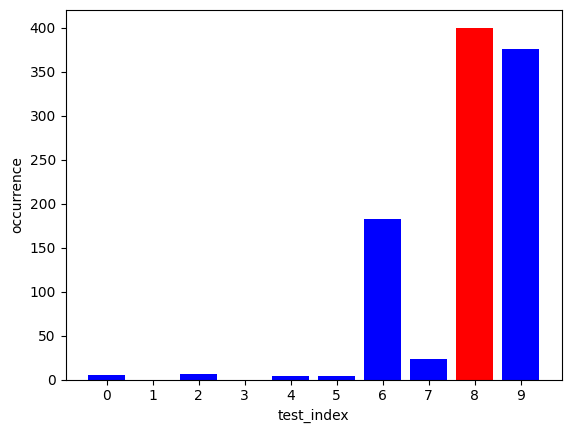

100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


array([[0.08587054, 0.07410558, 0.0747733 , 0.07454063, 0.07988571,
        0.07495879, 0.15619515, 0.15495118, 0.11369964, 0.11101949]])

array([ 31.,   0.,   0.,   1.,  10.,   5., 350., 395., 107., 101.])

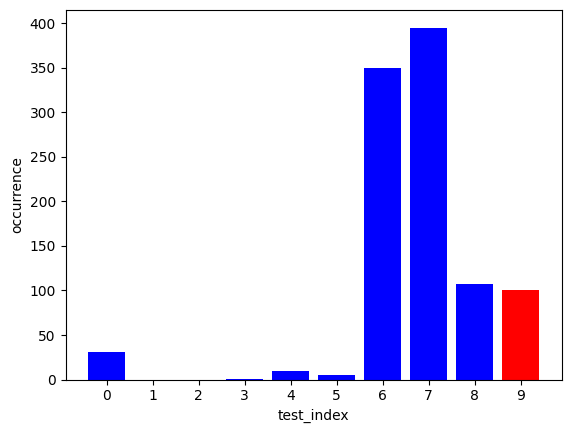

In [93]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t = load_voice(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t)
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [8]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
preload_models(use_smaller_models=True)

In [9]:
raw_prompts = [
  "A pessimist is one who makes difficulties of his opportunities and an optimist is one who makes opportunities of his difficulties.",
  "Don't judge each day by the harvest you reap but by the seeds that you plant.",
  "Challenges are what make life interesting and overcoming them is what makes life meaningful.",
  "Happiness lies not in the mere possession of money; it lies in the joy of achievement, in the thrill of creative effort.",
  "I disapprove of what you say, but I will defend to the death your right to say it.",
  "If I looked compared to others far, is because I stand on giant's shoulder.",
  "Never argue with stupid people, they will drag you down to their level and then beat you with experience.",
  "The greatest glory in living lies not in never falling, but in rising every time we fall.",
  "When you look into the abyss, the abyss also looks into you.",
  "Whoever fights monsters should see to it that in the process he does not become a monster."
]

basename = "woman-2"

for i, raw_prompt in enumerate(raw_prompts):
  generate(basename, raw_prompt, i)

woman-2: prompt-0
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


woman-2: prompt-1
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


woman-2: prompt-2
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


woman-2: prompt-3
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


woman-2: prompt-4
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


woman-2: prompt-5
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


woman-2: prompt-6
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


woman-2: prompt-7
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


woman-2: prompt-8
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


woman-2: prompt-9
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
